# Домашнее задание: классическое машинное обучение

## Взгляд на данные

In [16]:
import pandas as pd

df_shoes = pd.read_csv('Shoes_Data.csv')
df_shoes.head()

,title,price,rating,total_reviews,product_description,reviews,reviews_rating,Shoe Type
0,CLYMB Outdoor Sports Running Shoes for Mens Boy,₹279.00,2.9 out of 5 stars,2389 ratings,Elevate your style with this classy pair of Ru...,Not happy with product|| It's not as expected....,1.0 out of 5 stars|| 1.0 out of 5 stars|| 3.0 ...,Men
1,Bourge Men's Loire-z126 Running Shoes,₹479.00,3.9 out of 5 stars,11520 ratings,The product will be an excellent pick for you....,Memory cushioning in these shoes is the best f...,5.0 out of 5 stars|| 1.0 out of 5 stars|| 5.0 ...,Men
2,T-Rock Men's Sneaker,₹430.00,3.3 out of 5 stars,1251 ratings,Flaunt with these stylish and unique red casua...,Worth to its amount|| Go for it|| Perfect|| 5 ...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men
3,Robbie jones Sneakers Casual Canvas Fabric Col...,₹499.00,4.2 out of 5 stars,3 ratings,Robbie Jones Shoes Are Designed To Keeping In ...,Sup quality|| Good but not expected|| Awesome 👌.!,5.0 out of 5 stars|| 3.0 out of 5 stars|| 5.0 ...,Men
4,Sparx Men's Sd0323g Sneakers,₹499.00,4.2 out of 5 stars,20110 ratings,Sparx is a spectacular range of footwear from ...,Best|| Satisfied!|| Affordable beauty 😘😘😘😘 the...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men


Открываем данные в датафрейме и в текстовом редакторе и смотрим на них. Хватаемся за голову. Во-первых, весь рейтинг, цена и количество отзывов -- строки. Во-вторых, отдельные отзывы -- не отдельные строки! Тоже жуть. Для наших задач понадобятся два датафрейма. В-третьих, далеко не все отзывы -- английские. Тоже важно. Вряд ли мы сможем работать с хинди, урду или корейским = кажется, таких данных не очень много. Хотя можно было бы использовать, например, мультиязыковую модель и справиться с этим, в рамках этого задания придётся справляться по-другому, и есть вероятность, что для малопредставленных в отзывах языках это всё равно будет работать плохо.

## Предобработка текста

Что мы тут делаем и зачем? Приводим датафрейм в относительно удобоваримый вид. Приведём всё к нижнему регистру. Зачем? Потому что в датасете описания местами все с больших букв, нам это помешает. Лемматизируем. Зачем? Потому что хотим объединить разные формы слов в одну лемму, чтобы собрать несколько не очень частотных распределений в одно, более частотное. Выкинем из описаний не-латиницу, не-слова и не-цифры. Зачем? Потому что вряд ли по десятку примеров разных языков мы сможем что-то понять, и это может, наоборот, сбивать модель вместо того, чтобы учить её.

In [17]:
import re
import nltk
nltk.download('wordnet')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords

lemmatizer = WordNetLemmatizer()
stops = set(stopwords.words('english'))

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def clean_text(text, lemmatizer=lemmatizer, stops=stops):
    lemms = []
    words = word_tokenize(text)
    for word in words:
        word = word.lower()
        if re.match('[a-z0-9]*(\' -)?[a-z0-9]+', word) and word not in stops:
            lemma = lemmatizer.lemmatize(word, get_wordnet_pos(word))
            lemms.append(lemma)

    return ' '.join(lemms)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\M\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
df_shoes_1 = pd.DataFrame()
df_shoes_1['price'] = [float(n.split('₹')[1]) for n in df_shoes['price']]
df_shoes_1['description'] = [clean_text(description, lemmatizer) for description in df_shoes['product_description']]
df_shoes_1['title'] = [clean_text(title, lemmatizer) for title in df_shoes['title']]
df_shoes_1['rating'] = [float(n.split(' ')[0]) for n in df_shoes['rating']]
df_shoes_1['total_reviews'] = [int(n.split(' ')[0]) for n in df_shoes['total_reviews']]
df_shoes_1['type'] = [len(n) // 2 - 1 for n in df_shoes['Shoe Type']]

In [19]:
df_shoes_1.head()

,price,description,title,rating,total_reviews,type
0,279.0,elevate style classy pair run shoe house clymb...,clymb outdoor sport run shoe men boy,2.9,2389,0
1,479.0,product excellent pick ensures easy maintenance,bourge men loire-z126 run shoe,3.9,11520,0
2,430.0,flaunt stylish unique red casual shoe per late...,t-rock men sneaker,3.3,1251,0
3,499.0,robbie jones shoe design keep mind durability ...,robbie jones sneaker casual canvas fabric colo...,4.2,3,0
4,499.0,sparx spectacular range footwear house relaxo ...,sparx men sd0323g sneaker,4.2,20110,0


Ура, у нас есть датасет. Попробуем решить по нему изначальную задачу -- цену по описанию, не трогая остальное, чтобы посмотрееть, как получится

## Анализ

In [20]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

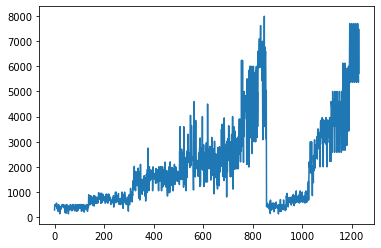

In [21]:
plt.plot(df_shoes_1['price'])
plt.show()

Не очень полезный график, напоминающий, что данные надо перемешать, а то некрасиво получится. Но мы можем понять, что цены распределены неравномерно, и посмотреть на это.

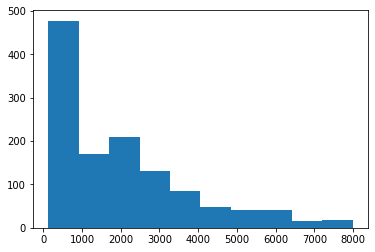

In [22]:
plt.hist(df_shoes_1['price'])
plt.show()

Так и есть! У нас чуть-чуть дорогих моделей и довольно много дешёвых

In [23]:
df_shoes_1.describe()

,price,rating,total_reviews,type
count,1230.000000,1230.000000,1230.000000,1230.000000
mean,2031.842268,3.964553,815.791057,0.304065
std,1729.425360,0.468047,3116.057954,0.460197
min,127.000000,1.000000,1.000000,0.000000
25%,622.250000,3.800000,26.000000,0.000000
50%,1588.000000,4.000000,118.000000,0.000000
75%,2844.687500,4.200000,440.750000,1.000000
max,7992.000000,5.000000,42193.000000,1.000000


Ну что ж. Наиболее дорогие 25% обуви -- разница в пять тысяч. Между остальными -- полторы тысячи -- тысяча -- пятьсот

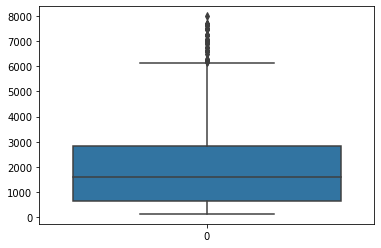

In [24]:
import seaborn as sns
ax = sns.boxplot(data=df_shoes_1['price'])

Нет нулей -- и хорошо. Но распределено неравномерно, давайте посмотрим, насколько.

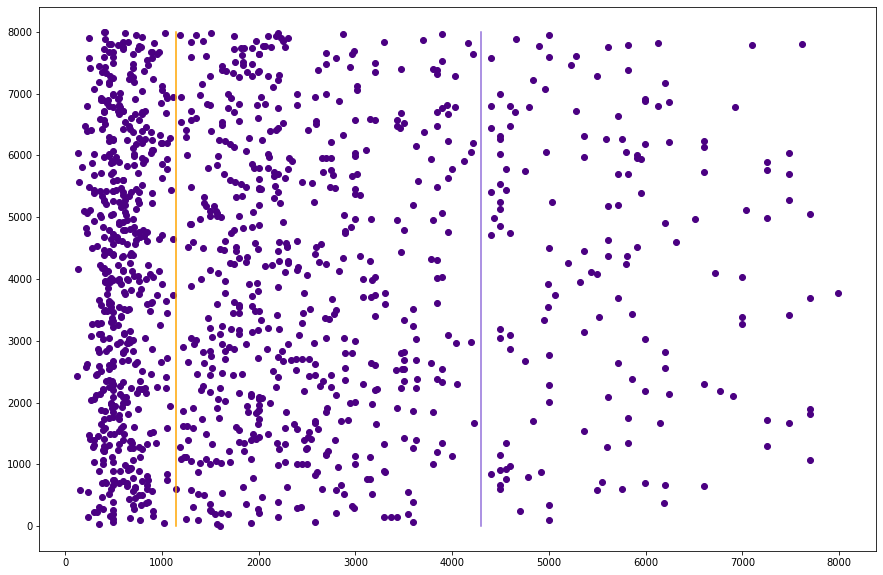

In [99]:
import matplotlib.pyplot as plt
import numpy as np
import random
x = df_shoes_1['price']
y = [random.randint(1, 8000) for i in range(len(df_shoes_1['price']))]
plt.figure(figsize = (15, 10)) 
plt.scatter(x, y, color='#4B0082')
plt.plot([1150, 1150],[0, 8000], color='#FFA500')
plt.plot([4300, 4300],[0, 8000], color='#9370DB')
plt.show()

Если мы попробуем хоть как-то разделить получившееся (по иксу -- цена, по игреку -- рандомные значения, чтобы всё в линию не склеивалось), то можно увидеть хорошее скопление до 1150 и какое-то относительное скопление где-то до 4200-4300. Давайте посмотрим, отличаются ли вообще слова в описаниях 

*функция для удобства -- чтобы не повторять одно и то же три раза*

In [134]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def print_wordclouds(filter_price, graph_title):
    text_cloud = ' '.join(df_shoes_1[filter_price]['description'])

    wordcloud = WordCloud(
        background_color ='white',
        width = 800,
        height = 400, 
    ).generate(text_cloud)

    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud)
    plt.axis("off") 
    plt.title(graph_title)
    plt.show()

Часть датасета первая. Ничего конкретного -- 'casual', 'style', 'sport' -- общее предназначение, а не, например, беговая обувь. Какие-нибудь характеристики, которые субъективны -- то же "модное", "идеальное" и прочее

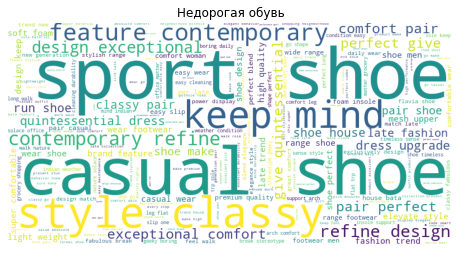

In [135]:
print_wordclouds(df_shoes_1['price'] < 1150, 'Недорогая обувь')

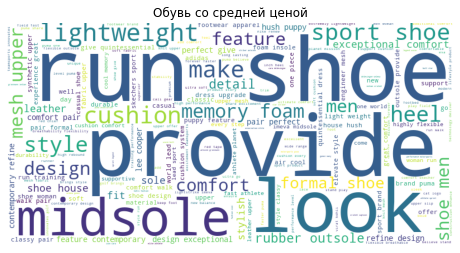

In [137]:
print_wordclouds((df_shoes_1['price'] > 1150) & (df_shoes_1['price'] < 4300), 'Обувь со средней ценой')

Появляются конкретные вещи -- беговая обувь (материалы сложнее -- дороже), супинатор (далеко так не во всех моделях есть эта ортопедическая деталь), пена с эффектом памяти -- тоже не сильно дёшево. Но оценочные вещи всё равно никуда не деваются.

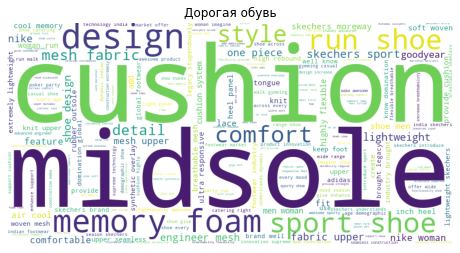

In [138]:
print_wordclouds(df_shoes_1['price'] > 4300, 'Дорогая обувь')

Итак, конкретика выходит на первый план! Подошва, супинатор, пена с эффектом памяти встречаются ещё чаще. Здесь определённо находится то, что можно описать, помимо абстрактных и субъективных категорий. Однако есл бы описанное мной разделение было жёстким -- счастье. Но и там, и там есть абстрактное и конкретное, просто в разных относительного общего объёма пропорциях, поэтому прямо совсем хорошо с идеальной точностью вряд ли всё получится предсказать. Но они отличаются -- и это уже хорошо

## Векторизация

In [29]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

Векторизуем данные -- Count и Tfidf векторайзеры, анализируем и слова, и n-граммы -- неизвестно, что сработает лучше. Не берём много признаков -- у нас всего чуть больше тысячи описаний

In [30]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np

tfidf_ngrams = TfidfVectorizer(max_features=200, analyzer='char', ngram_range=(3,3))
tfidf_words = TfidfVectorizer(max_features=200, analyzer='word')
cnt_ngrams = CountVectorizer(max_features=200, analyzer='char', ngram_range=(3,3))
cnt_words = CountVectorizer(max_features=200, analyzer='word')

X_tfidf_ngrams = tfidf_ngrams.fit_transform(df_shoes_1['description']).toarray()
X_tfidf_words = tfidf_words.fit_transform(df_shoes_1['description']).toarray()
X_cnt_ngrams = cnt_ngrams.fit_transform(df_shoes_1['description']).toarray()
X_cnt_words = cnt_words.fit_transform(df_shoes_1['description']).toarray()
Y = df_shoes_1['price']

In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(X_tfidf_ngrams, Y.values, train_size=0.8, random_state = 42)

In [33]:
all_data = {'tfidf_ngrams': X_tfidf_ngrams, 'tfidf_words': X_tfidf_words, 
             'cnt_ngrams': X_cnt_ngrams, 'cnt_words': X_cnt_words}

Создадим вот такую структуру -- иксы у нас разные, а игрек один

## Модели

Начнём сразу с более сложного, потому что у нас тексты и вектора, и в принципе не очень очевидная задача -- цена по описанию. Ну и библиотеки разные попробовать, не всё ж только паттерны sklearn запоминать, нужно и в других знать, как разобраться

### Catboost

In [141]:
#!pip install catboost
import catboost
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [142]:
boosting_model = catboost.CatBoostRegressor(n_estimators=200)

boosting_model.fit(X_train, Y_train)

Learning rate set to 0.132243
0:	learn: 1679.9843166	total: 912ms	remaining: 3m 1s
1:	learn: 1623.9011115	total: 1.3s	remaining: 2m 9s
2:	learn: 1569.4797686	total: 1.69s	remaining: 1m 51s
3:	learn: 1529.1235103	total: 1.94s	remaining: 1m 34s
4:	learn: 1485.8835628	total: 2.24s	remaining: 1m 27s
5:	learn: 1450.2047360	total: 2.69s	remaining: 1m 27s
6:	learn: 1408.6525378	total: 2.98s	remaining: 1m 22s
7:	learn: 1375.1021112	total: 3.36s	remaining: 1m 20s
8:	learn: 1343.1253299	total: 3.55s	remaining: 1m 15s
9:	learn: 1319.7085679	total: 3.89s	remaining: 1m 13s
10:	learn: 1295.8482894	total: 4.27s	remaining: 1m 13s
11:	learn: 1268.2083698	total: 4.62s	remaining: 1m 12s
12:	learn: 1243.6107382	total: 4.98s	remaining: 1m 11s
13:	learn: 1224.1665716	total: 5.29s	remaining: 1m 10s
14:	learn: 1206.8725496	total: 5.7s	remaining: 1m 10s
15:	learn: 1188.1178055	total: 6.12s	remaining: 1m 10s
16:	learn: 1165.0487301	total: 6.49s	remaining: 1m 9s
17:	learn: 1145.7573704	total: 6.96s	remaining: 1m

154:	learn: 509.0654688	total: 44.5s	remaining: 12.9s
155:	learn: 507.0275711	total: 44.7s	remaining: 12.6s
156:	learn: 504.0655709	total: 44.9s	remaining: 12.3s
157:	learn: 503.4367946	total: 45.3s	remaining: 12s
158:	learn: 501.7675696	total: 45.6s	remaining: 11.8s
159:	learn: 500.0774554	total: 45.9s	remaining: 11.5s
160:	learn: 499.4187122	total: 46.1s	remaining: 11.2s
161:	learn: 497.1274656	total: 46.3s	remaining: 10.9s
162:	learn: 495.7323374	total: 46.6s	remaining: 10.6s
163:	learn: 495.2071149	total: 46.9s	remaining: 10.3s
164:	learn: 494.9317811	total: 47.2s	remaining: 10s
165:	learn: 492.1662537	total: 47.5s	remaining: 9.72s
166:	learn: 491.9099469	total: 47.7s	remaining: 9.42s
167:	learn: 491.3033153	total: 47.9s	remaining: 9.13s
168:	learn: 490.2659870	total: 48.2s	remaining: 8.85s
169:	learn: 489.5303712	total: 48.5s	remaining: 8.55s
170:	learn: 488.3511341	total: 48.8s	remaining: 8.28s
171:	learn: 487.0921056	total: 49.2s	remaining: 8.01s
172:	learn: 486.6123658	total: 4

In [143]:
y_train_predicted = boosting_model.predict(X_train)
y_test_predicted = boosting_model.predict(X_test)

In [144]:
print(np.sqrt(mean_squared_error(Y_test, y_test_predicted)))
print(mean_absolute_error(Y_test, y_test_predicted))

946.715599868669
582.9278810153028


А ничего точность! С учётом того, что у нас выбросы с большими значениями -- для цены в 6000 эта ошибка не так уж велика, например, в процентном соотношении с учётом того, что дорогой обуви у нас в датасете немного

In [207]:
gs_model = catboost.CatBoostRegressor()
param_grid = {'n_estimators': [20, 50, 100, 150, 175, 200],
              'learning_rate': [0.03, 0.1],
              'depth': [4, 6, 10],
              'l2_leaf_reg': [1, 3, 5, 7, 9] 
             }

In [208]:
gs_model.grid_search(param_grid, X=X_train, y=Y_train)


bestTest = 1898.446741
bestIteration = 19

0:	loss: 1898.4467412	best: 1898.4467412 (0)	total: 2.18s	remaining: 6m 30s

bestTest = 1335.430196
bestIteration = 19

1:	loss: 1335.4301962	best: 1335.4301962 (1)	total: 3.8s	remaining: 5m 38s

bestTest = 1910.510942
bestIteration = 19

2:	loss: 1910.5109420	best: 1335.4301962 (1)	total: 5.46s	remaining: 5m 21s

bestTest = 1335.909388
bestIteration = 19

3:	loss: 1335.9093885	best: 1335.4301962 (1)	total: 6.85s	remaining: 5m 1s

bestTest = 1921.647315
bestIteration = 19

4:	loss: 1921.6473154	best: 1335.4301962 (1)	total: 8.07s	remaining: 4m 42s

bestTest = 1364.007201
bestIteration = 19

5:	loss: 1364.0072007	best: 1335.4301962 (1)	total: 9.37s	remaining: 4m 31s

bestTest = 1931.309101
bestIteration = 19

6:	loss: 1931.3091007	best: 1335.4301962 (1)	total: 10.7s	remaining: 4m 23s

bestTest = 1364.221552
bestIteration = 19

7:	loss: 1364.2215515	best: 1335.4301962 (1)	total: 12.1s	remaining: 4m 20s

bestTest = 1942.263455
bestIteration = 19


bestTest = 1384.358527
bestIteration = 19

67:	loss: 1384.3585274	best: 1011.2930101 (53)	total: 9m 25s	remaining: 15m 32s

bestTest = 1982.963381
bestIteration = 19

68:	loss: 1982.9633805	best: 1011.2930101 (53)	total: 9m 29s	remaining: 15m 15s

bestTest = 1403.946486
bestIteration = 19

69:	loss: 1403.9464861	best: 1011.2930101 (53)	total: 9m 32s	remaining: 14m 59s

bestTest = 1410.288247
bestIteration = 49

70:	loss: 1410.2882471	best: 1011.2930101 (53)	total: 9m 40s	remaining: 14m 51s

bestTest = 1076.395164
bestIteration = 49

71:	loss: 1076.3951640	best: 1011.2930101 (53)	total: 9m 48s	remaining: 14m 42s

bestTest = 1457.572554
bestIteration = 49

72:	loss: 1457.5725538	best: 1011.2930101 (53)	total: 9m 56s	remaining: 14m 33s

bestTest = 1110.747198
bestIteration = 49

73:	loss: 1110.7471977	best: 1011.2930101 (53)	total: 10m 3s	remaining: 14m 25s

bestTest = 1492.27386
bestIteration = 49

74:	loss: 1492.2738601	best: 1011.2930101 (53)	total: 10m 11s	remaining: 14m 16s

bestTes


bestTest = 1069.165113
bestIteration = 49

133:	loss: 1069.1651131	best: 971.6738079 (101)	total: 46m 22s	remaining: 15m 55s

bestTest = 1569.45952
bestIteration = 49

134:	loss: 1569.4595203	best: 971.6738079 (101)	total: 48m 41s	remaining: 16m 13s

bestTest = 1115.810456
bestIteration = 49

135:	loss: 1115.8104563	best: 971.6738079 (101)	total: 50m 51s	remaining: 16m 27s

bestTest = 1606.156936
bestIteration = 49

136:	loss: 1606.1569360	best: 971.6738079 (101)	total: 53m 5s	remaining: 16m 39s

bestTest = 1147.387509
bestIteration = 49

137:	loss: 1147.3875090	best: 971.6738079 (101)	total: 55m 24s	remaining: 16m 51s

bestTest = 1654.775886
bestIteration = 49

138:	loss: 1654.7758863	best: 971.6738079 (101)	total: 57m 37s	remaining: 16m 59s

bestTest = 1175.929578
bestIteration = 49

139:	loss: 1175.9295776	best: 971.6738079 (101)	total: 1h 14s	remaining: 17m 12s

bestTest = 1100.911555
bestIteration = 99

140:	loss: 1100.9115553	best: 971.6738079 (101)	total: 1h 5m 7s	remaining: 18

{'params': {'depth': 6,
  'l2_leaf_reg': 1,
  'iterations': 175,
  'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,

In [145]:
best_catboost_model = catboost.CatBoostRegressor(depth=6, l2_leaf_reg=1, iterations=175, learning_rate=0.1)

best_catboost_model.fit(X_train, Y_train)

0:	learn: 1691.8296841	total: 367ms	remaining: 1m 3s
1:	learn: 1639.2743883	total: 819ms	remaining: 1m 10s
2:	learn: 1583.4933385	total: 1.51s	remaining: 1m 26s
3:	learn: 1544.4885320	total: 2s	remaining: 1m 25s
4:	learn: 1501.2922678	total: 2.42s	remaining: 1m 22s
5:	learn: 1471.4399858	total: 2.68s	remaining: 1m 15s
6:	learn: 1432.2196569	total: 3.13s	remaining: 1m 15s
7:	learn: 1400.8887387	total: 3.46s	remaining: 1m 12s
8:	learn: 1369.9225569	total: 3.93s	remaining: 1m 12s
9:	learn: 1338.9009668	total: 4.29s	remaining: 1m 10s
10:	learn: 1316.0408602	total: 4.65s	remaining: 1m 9s
11:	learn: 1286.6075168	total: 5.07s	remaining: 1m 8s
12:	learn: 1259.7842435	total: 5.42s	remaining: 1m 7s
13:	learn: 1239.3456272	total: 5.9s	remaining: 1m 7s
14:	learn: 1224.1858398	total: 6.29s	remaining: 1m 7s
15:	learn: 1202.9430771	total: 6.74s	remaining: 1m 6s
16:	learn: 1185.7823939	total: 7.16s	remaining: 1m 6s
17:	learn: 1165.3356437	total: 7.62s	remaining: 1m 6s
18:	learn: 1154.3880688	total: 8.

155:	learn: 510.4093757	total: 54.1s	remaining: 6.59s
156:	learn: 509.4198898	total: 54.7s	remaining: 6.27s
157:	learn: 507.9557653	total: 55.2s	remaining: 5.94s
158:	learn: 506.5203967	total: 55.6s	remaining: 5.59s
159:	learn: 504.7387529	total: 55.8s	remaining: 5.23s
160:	learn: 503.4525896	total: 56.3s	remaining: 4.89s
161:	learn: 501.4085055	total: 56.6s	remaining: 4.54s
162:	learn: 500.8930424	total: 57s	remaining: 4.2s
163:	learn: 500.5294706	total: 57.3s	remaining: 3.84s
164:	learn: 499.8673250	total: 57.7s	remaining: 3.5s
165:	learn: 499.4883765	total: 58.1s	remaining: 3.15s
166:	learn: 498.4766557	total: 58.6s	remaining: 2.81s
167:	learn: 496.3952245	total: 58.9s	remaining: 2.46s
168:	learn: 494.8106470	total: 59.3s	remaining: 2.1s
169:	learn: 492.8554510	total: 59.9s	remaining: 1.76s
170:	learn: 491.6986088	total: 1m	remaining: 1.41s
171:	learn: 491.1565243	total: 1m	remaining: 1.06s
172:	learn: 490.6995324	total: 1m 1s	remaining: 708ms
173:	learn: 489.6496691	total: 1m 1s	re

In [146]:
y_train_predicted_best = best_catboost_model.predict(X_train)
y_test_predicted_best = best_catboost_model.predict(X_test)

In [147]:
print(np.sqrt(mean_squared_error(Y_test, y_test_predicted_best)))
print(mean_absolute_error(Y_test, y_test_predicted_best))

915.4978324202141
577.6987455654712


Значения лучше, но ненамного

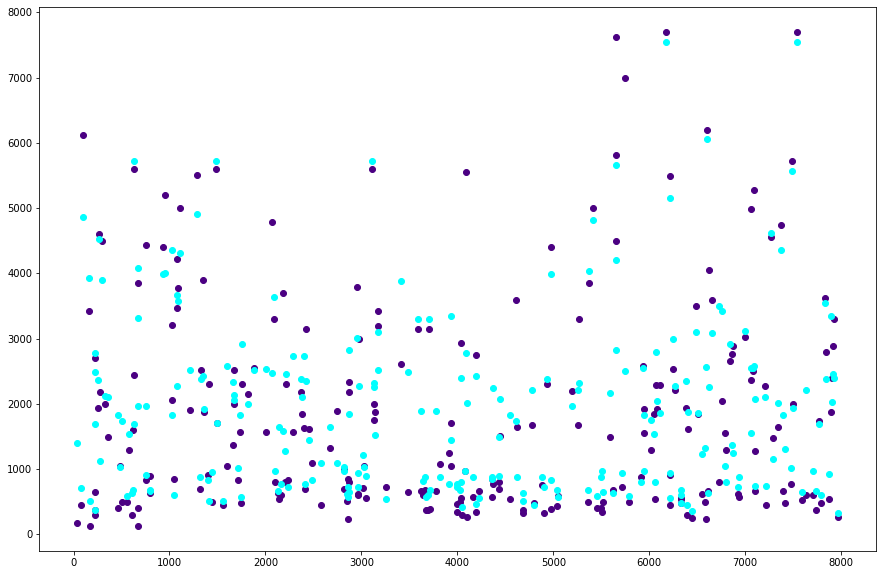

RMSE  915.4978324202141
MAE   577.6987455654712


In [148]:
x = [random.randint(1, 8000) for i in range(len(Y_test))]
plt.figure(figsize = (15, 10))
plt.scatter(x, Y_test, color='#4B0082')
plt.scatter(x, y_test_predicted_best, color='cyan')
plt.show()

print('RMSE ', np.sqrt(mean_squared_error(Y_test, y_test_predicted_best)))
print('MAE  ', mean_absolute_error(Y_test, y_test_predicted_best))

Красиво! И посмотрите, как бирюзовые предсказанные и фиолетовые настоящие точки близки друг к другу. По иксу случайные значения, чтобы точки было видно, по игреку -- цена

### Sklearn, гридсёрч

In [35]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import SGDRegressor

from sklearn.model_selection import GridSearchCV

Итак, наша основная часть. Функция для удобства, чтобы не повторять код:

In [121]:
def gridsearch_for_all_data(all_data, answers, template_model, param_grid):
    for name_data, data in all_data.items():
        model = template_model
        X_train, X_test, Y_train, Y_test = train_test_split(data, answers.values, train_size=0.8, random_state = 42)
        grid_model = GridSearchCV(model, param_grid)
        print('*************************************')
        grid_model.fit(X_train, Y_train)
        preds = grid_model.predict(X_test)
        print(name_data)
        print(grid_model.best_params_)
        print(grid_model.best_estimator_)
        print('RMSE')
        print(np.sqrt(mean_squared_error(Y_test, preds)))
        print('MAE')
        print(mean_absolute_error(Y_test, preds))

### Линейная регрессия

In [79]:
from sklearn.linear_model import LinearRegression

param_grid = {
}

gridsearch_for_all_data(all_data, Y, LinearRegression(), param_grid)

*************************************


C:\Users\M\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


tfidf_ngrams
{}
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
RMSE
1253.5744602743678
MAE
895.6350674387219
*************************************


C:\Users\M\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


tfidf_words
{}
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
RMSE
1200.0614687080251
MAE
852.1916954659831
*************************************


C:\Users\M\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


cnt_ngrams
{}
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
RMSE
1347.0449557013976
MAE
946.6469172113991
*************************************


C:\Users\M\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


cnt_words
{}
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
RMSE
1317.3263245058056
MAE
935.5471614735742


По метрикам похуже catboost'а, идейно -- самое простое, что можно сделать. Работает.

### AdaBoostRegressor

In [63]:
from sklearn.ensemble import AdaBoostRegressor

param_grid = {'n_estimators' : (10, 20, 50, 55, 70),
             'loss': ('square', 'linear'),
             }

gridsearch_for_all_data(all_data, Y, AdaBoostRegressor(), param_grid)

*************************************


C:\Users\M\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


tfidf_ngrams
{'loss': 'linear', 'n_estimators': 10}
AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=10, random_state=None)
RMSE
1331.2695165194084
MAE
1096.6736719773191
*************************************


C:\Users\M\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


tfidf_words
{'loss': 'linear', 'n_estimators': 10}
AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=10, random_state=None)
RMSE
1486.2359636932151
MAE
1215.7650643253555
*************************************


C:\Users\M\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


cnt_ngrams
{'loss': 'linear', 'n_estimators': 20}
AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=20, random_state=None)
RMSE
1481.9187015194177
MAE
1263.2895551949168
*************************************


C:\Users\M\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


cnt_words
{'loss': 'linear', 'n_estimators': 20}
AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=20, random_state=None)
RMSE
1510.938365180181
MAE
1287.7857884825544


Ещё один бустинг, у которого результаты тоже хуже почти в два раз. Более подробный анализ -- ниже

### SGDRegressor

In [78]:
from sklearn.linear_model import SGDRegressor
param_grid = {
    'alpha' : (10, 1, 0.1, 0.01, 0.001),
    'max_iter' : (1000, 1100, 1200, 1300, 1400, 1500),
    'penalty': ('l2', 'elasticnet')
}
gridsearch_for_all_data(all_data, Y, SGDRegressor(), param_grid)

*************************************


C:\Users\M\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\M\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\M\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\M\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\M\Anaconda3\lib\site-packages\skle

C:\Users\M\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\M\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\M\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\M\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


tfidf_ngrams
{'alpha': 0.001, 'max_iter': 1500, 'penalty': 'elasticnet'}
SGDRegressor(alpha=0.001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1500,
             n_iter_no_change=5, penalty='elasticnet', power_t=0.25,
             random_state=None, shuffle=True, tol=0.001,
             validation_fraction=0.1, verbose=0, warm_start=False)
RMSE
1224.6374929377214
MAE
902.3625286080253
*************************************


C:\Users\M\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\M\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\M\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\M\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\M\Anaconda3\lib\site-packages\sklearn\linear_mo

C:\Users\M\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\M\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\M\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


tfidf_words
{'alpha': 0.001, 'max_iter': 1400, 'penalty': 'elasticnet'}
SGDRegressor(alpha=0.001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1400,
             n_iter_no_change=5, penalty='elasticnet', power_t=0.25,
             random_state=None, shuffle=True, tol=0.001,
             validation_fraction=0.1, verbose=0, warm_start=False)
RMSE
1145.505259444649
MAE
825.8231191624418
*************************************
cnt_ngrams
{'alpha': 10, 'max_iter': 1100, 'penalty': 'l2'}
SGDRegressor(alpha=10, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1100,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm

C:\Users\M\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


cnt_words
{'alpha': 0.1, 'max_iter': 1100, 'penalty': 'elasticnet'}
SGDRegressor(alpha=0.1, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1100,
             n_iter_no_change=5, penalty='elasticnet', power_t=0.25,
             random_state=None, shuffle=True, tol=0.001,
             validation_fraction=0.1, verbose=0, warm_start=False)
RMSE
1220.6711836331142
MAE
926.0117305662517


Уже чуть интересней! Но со всем перебором параметров всё-таки не удаётся приблизиться так, как с catboost

### Случайный лес

In [96]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {'n_estimators': (50, 100, 150, 200),
              'max_depth': (5, 7, 10, 15, 20),
              'min_samples_split': (2, 3, 4), 
              'min_samples_leaf': (1, 2, 3)
}

gridsearch_for_all_data(all_data, Y, RandomForestRegressor(), param_grid)

*************************************


C:\Users\M\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


tfidf_ngrams
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
RMSE
995.0804266182937
MAE
610.6804177618213
*************************************


C:\Users\M\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


tfidf_words
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
RMSE
927.255675753443
MAE
611.495996446367
*************************************


C:\Users\M\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


cnt_ngrams
{'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
RMSE
953.4414380708282
MAE
587.129383307963
*************************************


C:\Users\M\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


cnt_words
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
RMSE
909.4122705467373
MAE
593.8957411229685


Мог бы переобучиться, но обрезка и ограничения сделали своё дело -- случайные леса неплохо живут с тем фактом, что у нас в одном диапазоне примеров мало, а в другом -- много

### GradientBoostingRegressor

In [98]:
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {'n_estimators': (50, 100, 150, 200),
              'min_samples_leaf': (1, 2, 3),
              'max_depth': (2, 3, 4),
              'max_leaf_nodes': (None, 5, 6, 10),
              'n_iter_no_change': (None, 5)
}

gridsearch_for_all_data(all_data, Y, GradientBoostingRegressor(), param_grid)

*************************************


C:\Users\M\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


tfidf_ngrams
{'max_depth': 4, 'max_leaf_nodes': 10, 'min_samples_leaf': 3, 'n_estimators': 200, 'n_iter_no_change': None}
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=10,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
RMSE
926.2959253577787
MAE
563.5144610016928
*************************************


C:\Users\M\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


tfidf_words
{'max_depth': 4, 'max_leaf_nodes': None, 'min_samples_leaf': 3, 'n_estimators': 200, 'n_iter_no_change': None}
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
RMSE
949.4636448539213
MAE
635.9374498268577
*************************************


C:\Users\M\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


cnt_ngrams
{'max_depth': 4, 'max_leaf_nodes': 10, 'min_samples_leaf': 3, 'n_estimators': 200, 'n_iter_no_change': None}
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=10,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
RMSE
951.6024429752676
MAE
607.5096352494883
*************************************


C:\Users\M\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


cnt_words
{'max_depth': 4, 'max_leaf_nodes': None, 'min_samples_leaf': 3, 'n_estimators': 200, 'n_iter_no_change': None}
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
RMSE
941.1616426824811
MAE
628.0611229620629


Ещё один бустинг, который неожиданно хорош для этой задачи

## Оценка результатов

In [126]:
def validate_results(model, data, answers):
    
    X_train, X_test, Y_train, Y_test = train_test_split(data, Y.values, 
                                                        train_size=0.8, random_state = 23)
    model.fit(X_train, Y_train)
    preds = model.predict(X_test)
    
    x = [random.randint(1, 8000) for i in range(len(Y_test))]
    plt.figure(figsize = (15, 10))
    plt.scatter(x, Y_test, color='#4B0082')
    plt.scatter(x, preds, color='cyan')
    plt.show()

    print('RMSE ', np.sqrt(mean_squared_error(Y_test, preds)))
    print('MAE  ', mean_absolute_error(Y_test, preds))

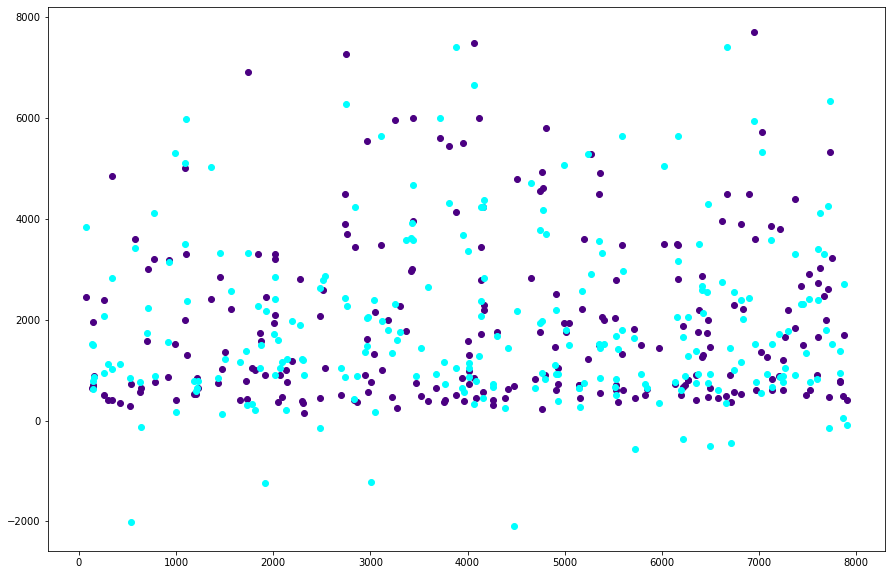

RMSE  1290.0769836221218
MAE   922.264834861877


In [127]:
validate_results(LinearRegression(), all_data['tfidf_words'], Y)

Линейная регрессия. Отрицательные цены на ботинки -- это весело, но такого не бывает. Из-за этого отчасти точность не очень. Возможно, нужна куда более тонкая настройка и параметров, и датасета

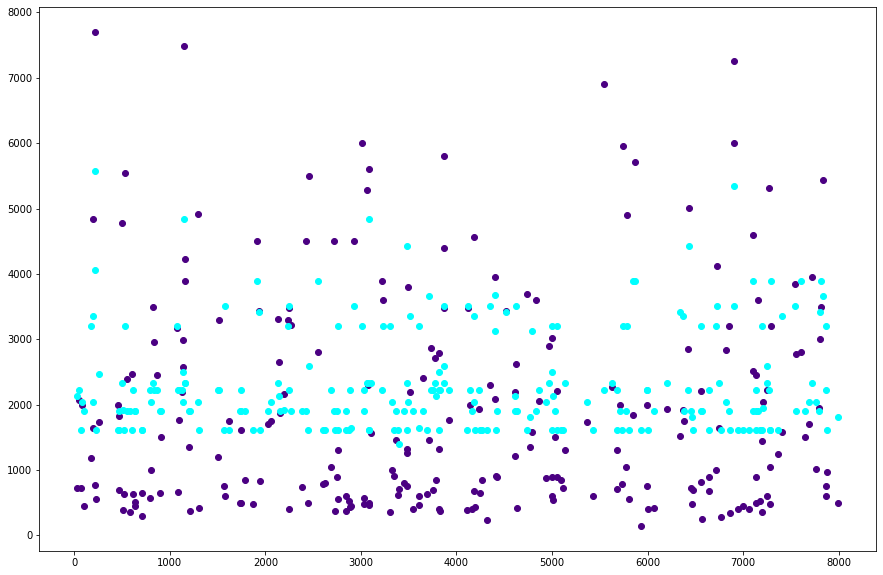

RMSE  1362.0331536249207
MAE   1134.8928204166727


In [128]:
validate_results(AdaBoostRegressor(loss='linear', n_estimators=10), all_data['tfidf_ngrams'], Y)

Ада. Тоже красиво, но наша основная масса обуви не предсказывается хорошо. Вероятно, эта модель была бы хороша в случае наличия выбросов в обе стороны от среднего, а не как у нас

C:\Users\M\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


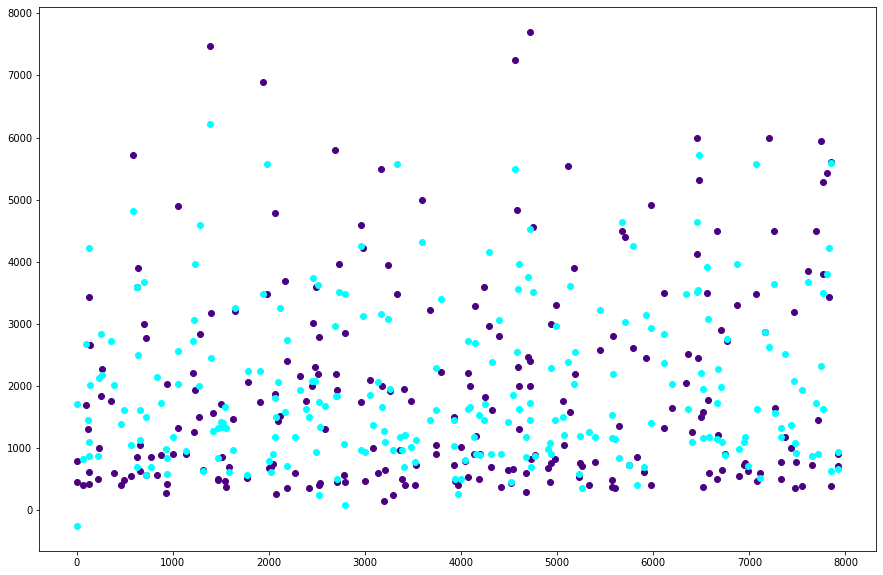

RMSE  1088.766338933583
MAE   800.8631437005225


In [129]:
validate_results(SGDRegressor(alpha=0.001, max_iter=1400, penalty='elasticnet'), all_data['tfidf_words'], Y)

Уже гораздо ближе к правде, но выбросы так и не предсказываются хорошо -- и из-за этого ошибка больше

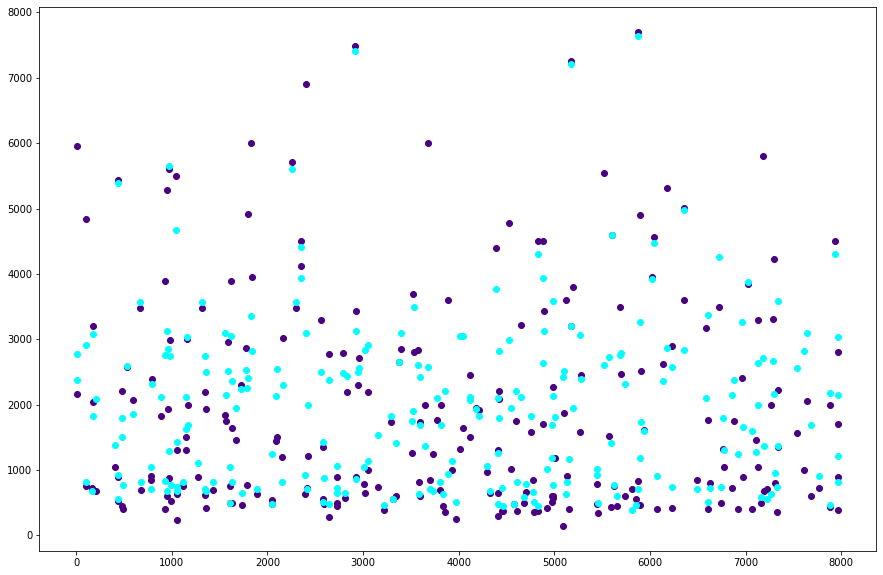

RMSE  938.9163681724839
MAE   601.1587215739086


In [130]:
validate_results(RandomForestRegressor(max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=100),
                 all_data['cnt_ngrams'], Y)
#RMSE
#953.4414380708282
#MAE
#587.129383307963

Восхитительно! Даже в выбросах точки почти перекрывают друг друга. Но при этом есть и значения с большой ошибкой

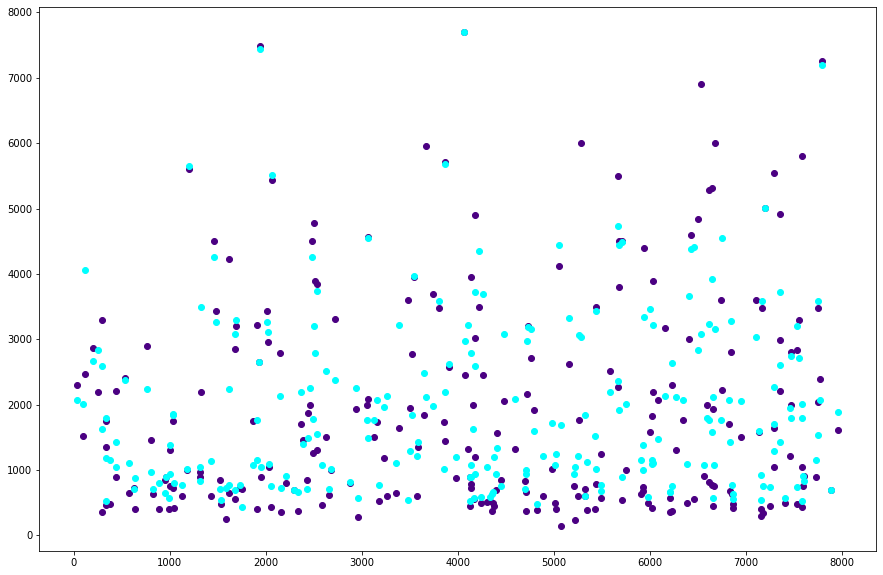

RMSE  923.8979374640378
MAE   583.4503680736824


In [131]:
validate_results(RandomForestRegressor(max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200),
                 all_data['cnt_words'], Y)
#RMSE
#909.4122705467373
#MAE
#593.8957411229685

Аналогично предыдущему, почти одинаково -- на разных наборах обработки -- слова и n-граммы

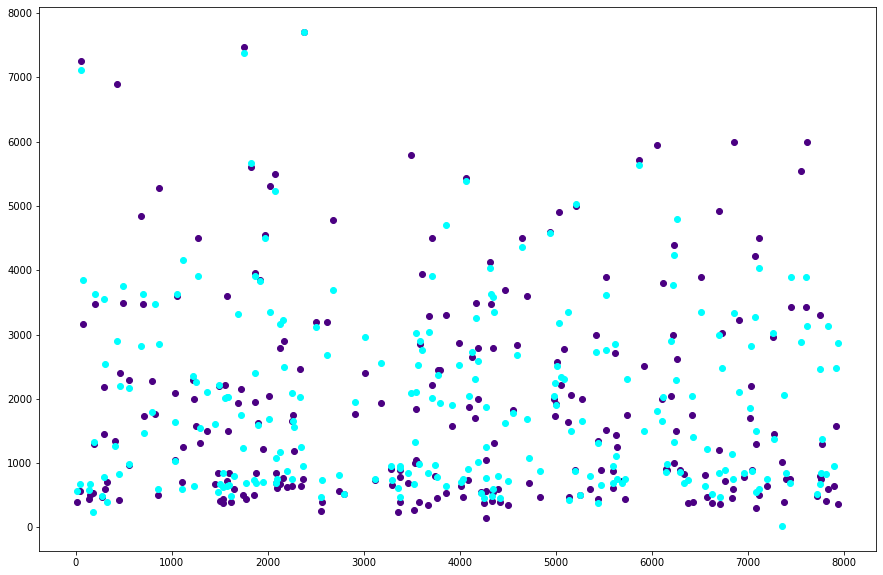

RMSE  929.3608204340595
MAE   554.4147908673922


In [132]:
validate_results(GradientBoostingRegressor(max_depth=4, max_leaf_nodes=10, min_samples_leaf=3, 
                                           n_estimators=200, n_iter_no_change=None), all_data['tfidf_ngrams'], Y)

Похоже на результаты случайного леса -- в общем-то, они все примерно одинаково хороши, но это уже бустинг

## Краткие итоги

Несмотря на то, что мы могли бы в этой задаче ожидать от простой модели хорошего результата, а то более сложных -- переобучения, этого всё же, видимо, не случилось. Хорошо показали себя леса и бустинги, но естественно, с тщательной обрезкой по параметрам. Результат, в принципе, может нас даже удовлетворить -- с учётом особенностей датасета и задачи. Среди векторизации сложно выделить только один набор -- хорошее или плюс-минус похожее качество получается на всех, но тем не менее, для некоторых моделей оказались лучше одни наборы, для некоторых -- другие. В принципе, такой гридсёрч с перебором наборов по-разному обработанных данных -- хорошая идея, какая-то обработка на какой-то из моделей может оказаться не слишком намного, но лучше других, и так можно выяснить, как же оптимально предобрабатывать данные для этой задачи